In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob
import copy

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=8)
client

<Client: 'tcp://127.0.0.1:41305' processes=8 threads=8, memory=22.46 GiB>

In [3]:
db = '/g/data/e14/rmh561/access-om2/archive/databases/cc_database_era5'
session = cc.database.create_session(db)

In [4]:
exptdict = OrderedDict([
    ('1 JRA55 RYF',  {'expt':'1deg_jra55_ryf','cy':1,'color':'C0'}),
    ('1 ERA5 RYF',  {'expt':'1deg_era5_ryf','cy':1,'color':'C1'}),
#    ('1 JRA55 IAF',  {'expt':'1deg_jra55_iaf','cy':1,'color':'C2'}),
#    ('1 ERA5 IAF',  {'expt':'1deg_era5_iaf','cy':1,'color':'C3'})
])

In [5]:
# WOA13 data:
WOA13 = xr.open_mfdataset('/g/data/ik11/observations/woa13/10_KDS50/woa13_ts_*')

## Just checking the final data for each expt.

In [6]:
for ekey in exptdict.keys():
    variable = 'temp_global_ave'
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
    start_year = var.time.isel(time=0)
    end_year = var.time.isel(time=-1)
    print(expt, start_year.values, end_year.values)

1deg_jra55_ryf 1900-01-02 00:00:00 2000-01-01 00:00:00
1deg_era5_ryf 1900-01-02 00:00:00 2000-01-01 00:00:00


## Scalar diagnostics

In [7]:
def plot_timeseries(variable,keys=exptdict.keys(),ncfile=None):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session,ncfile=ncfile)
        if (exptdict[ekey]['cy'] == 1):
            var.plot(label=ekey,color=exptdict[ekey]['color'])
        else:
            var.plot(color=exptdict[ekey]['color'])
    plt.xlabel('Time (years)')
    plt.legend()
    return

### Global Average Temperature

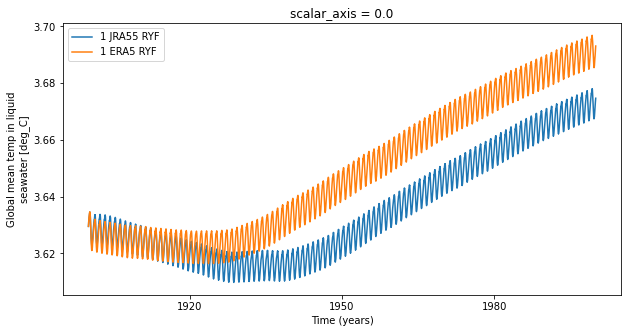

In [8]:
plot_timeseries('temp_global_ave')

### Global Average Salinity

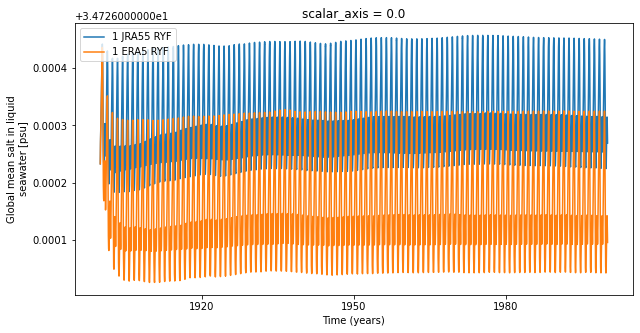

In [9]:
plot_timeseries('salt_global_ave')

### Surface Temperature

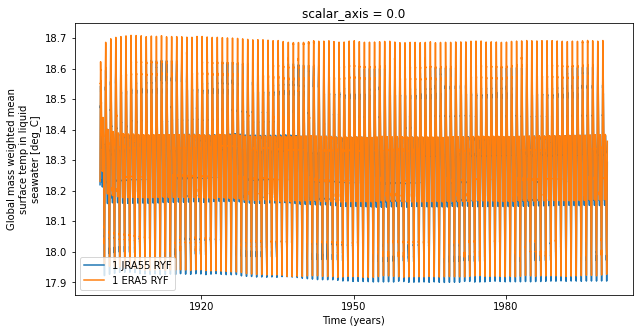

In [10]:
plot_timeseries('temp_surface_ave')

### Surface Salinity

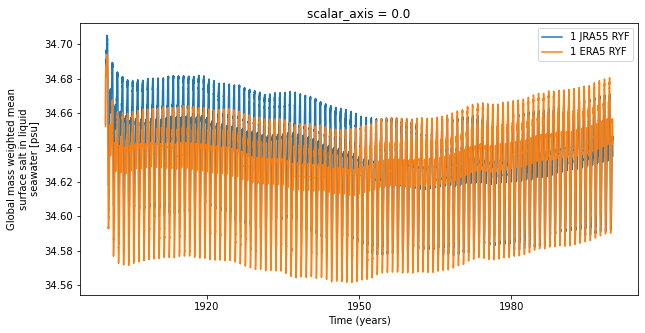

In [11]:
plot_timeseries('salt_surface_ave')

### Total Kinetic Energy

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


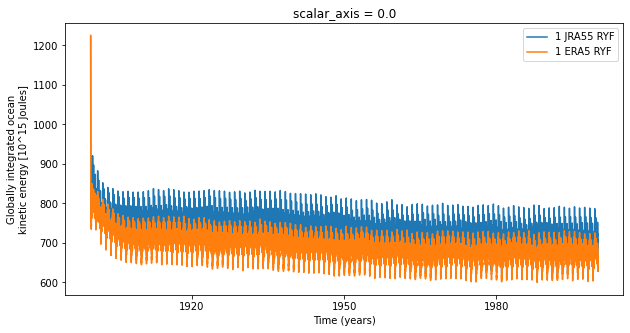

In [12]:
plot_timeseries('ke_tot')

## Area-Averaged Tracer Diagnostics

In [13]:
def plot_depthintv(variable,zlims,end_time='2200-01-01',keys=exptdict.keys()):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        expt = exptdict[ekey]['expt']
        print(expt)
        var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        area = cc.querying.getvar(expt,'area_t',session,n=1)
        dzt = cc.querying.getvar(expt,'dzt',session,n=1).isel(time=0)
        vol = (dzt*area).sel(st_ocean = slice(zlims[0],zlims[1]))
        var = var.sel(st_ocean = slice(zlims[0],zlims[1]))
        varmean = ((var*vol).sum('st_ocean').sum('yt_ocean').sum('xt_ocean')/(vol.sum('st_ocean').sum('yt_ocean').sum('xt_ocean')))
        (varmean-273.15).plot(label=ekey)
    plt.legend()
    plt.title(str(zlims[0]) + ' - ' + str(zlims[1]) + 'm ' + variable)

### Upper 700m temp

1deg_jra55_ryf


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1deg_era5_ryf
CPU times: user 3min 19s, sys: 14.4 s, total: 3min 33s
Wall time: 4min 10s


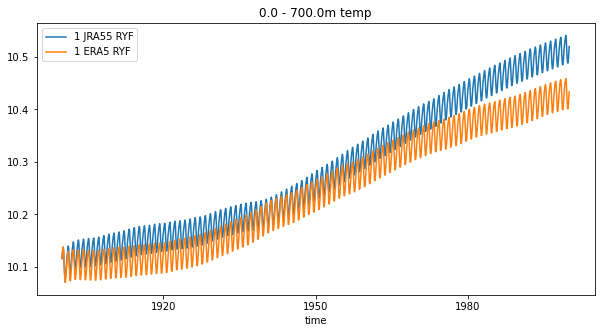

In [14]:
%%time
keys = exptdict.keys()
plot_depthintv('temp',[0.,700.],keys=keys)

### Upper 2000m temp

1deg_jra55_ryf
1deg_era5_ryf


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.78 GiB -- Worker memory limit: 2.81 GiB


CPU times: user 3min 8s, sys: 13.8 s, total: 3min 22s
Wall time: 3min 58s


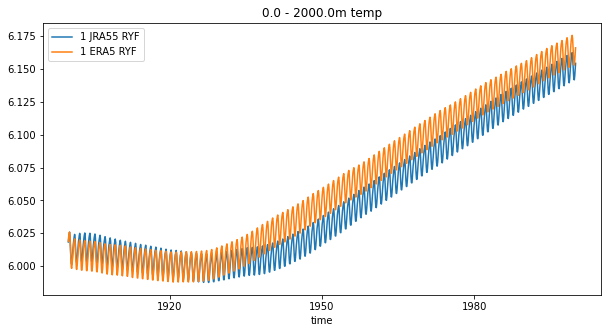

In [15]:
%%time
keys = exptdict.keys()
plot_depthintv('temp',[0.,2000.],keys=keys)

### 2000m-bottom temp

1deg_jra55_ryf
1deg_era5_ryf
CPU times: user 1min 58s, sys: 7.79 s, total: 2min 5s
Wall time: 2min 25s


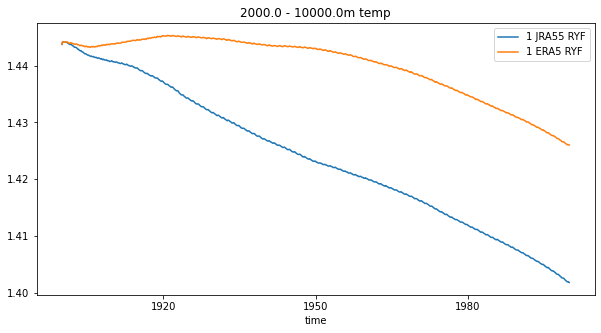

In [16]:
%%time
keys = exptdict.keys()
plot_depthintv('temp',[2000.,10000.],keys=keys)

## Surface properties

Text(0.5, 1.0, 'ERA-5 - JRA-55 SSS (psu)')

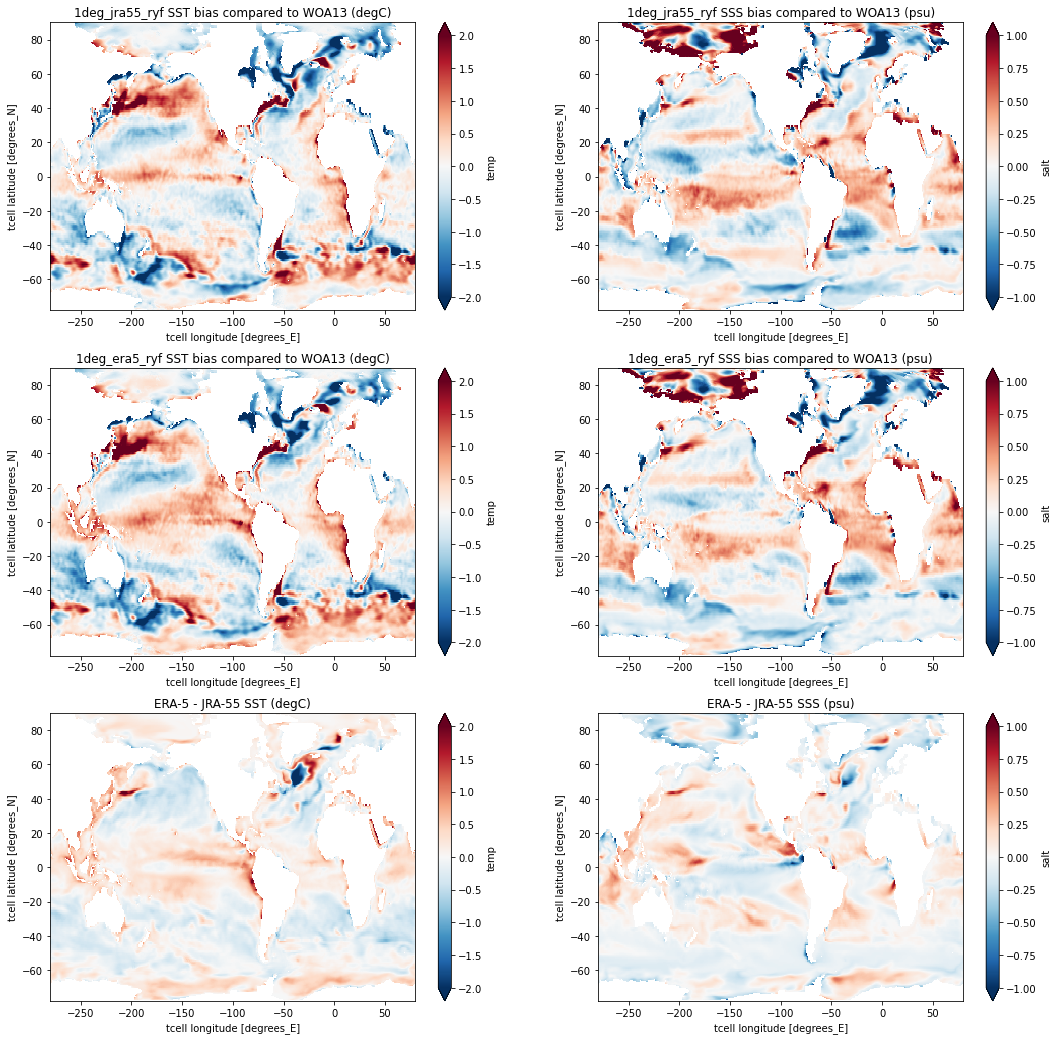

In [17]:
keys = exptdict.keys()
times = ['1995-01-01','2000-01-01']
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(18,18))
sst = {}
sss = {}
for i, ekey in enumerate(keys):
    expt = exptdict[ekey]['expt']
    sst[ekey] = cc.querying.getvar(expt,'temp',session).isel(st_ocean=0).sel(time=slice(times[0],times[1])).mean('time')-273.15
    sss[ekey] = cc.querying.getvar(expt,'salt',session).isel(st_ocean=0).sel(time=slice(times[0],times[1])).mean('time')
    
    
    sst_bias = sst[ekey] - WOA13.temp.isel(ZT=0).mean('time').values
    sss_bias = sss[ekey] - WOA13.salt.isel(ZT=0).mean('time').values
    sst_bias.plot(ax=axes[i][0],vmin=-2.,vmax=2.,cmap='RdBu_r')
    axes[i][0].set_title(expt + ' SST bias compared to WOA13 (degC)')
    sss_bias.plot(ax=axes[i][1],vmin=-1.,vmax=1.,cmap='RdBu_r')
    axes[i][1].set_title(expt + ' SSS bias compared to WOA13 (psu)')
    
(sst['1 ERA5 RYF']-sst['1 JRA55 RYF']).plot(ax=axes[i+1][0],vmin=-2.,vmax=2.,cmap='RdBu_r')
axes[i+1][0].set_title('ERA-5 - JRA-55 SST (degC)')
(sss['1 ERA5 RYF']-sss['1 JRA55 RYF']).plot(ax=axes[i+1][1],vmin=-1.,vmax=1.,cmap='RdBu_r')
axes[i+1][1].set_title('ERA-5 - JRA-55 SSS (psu)')

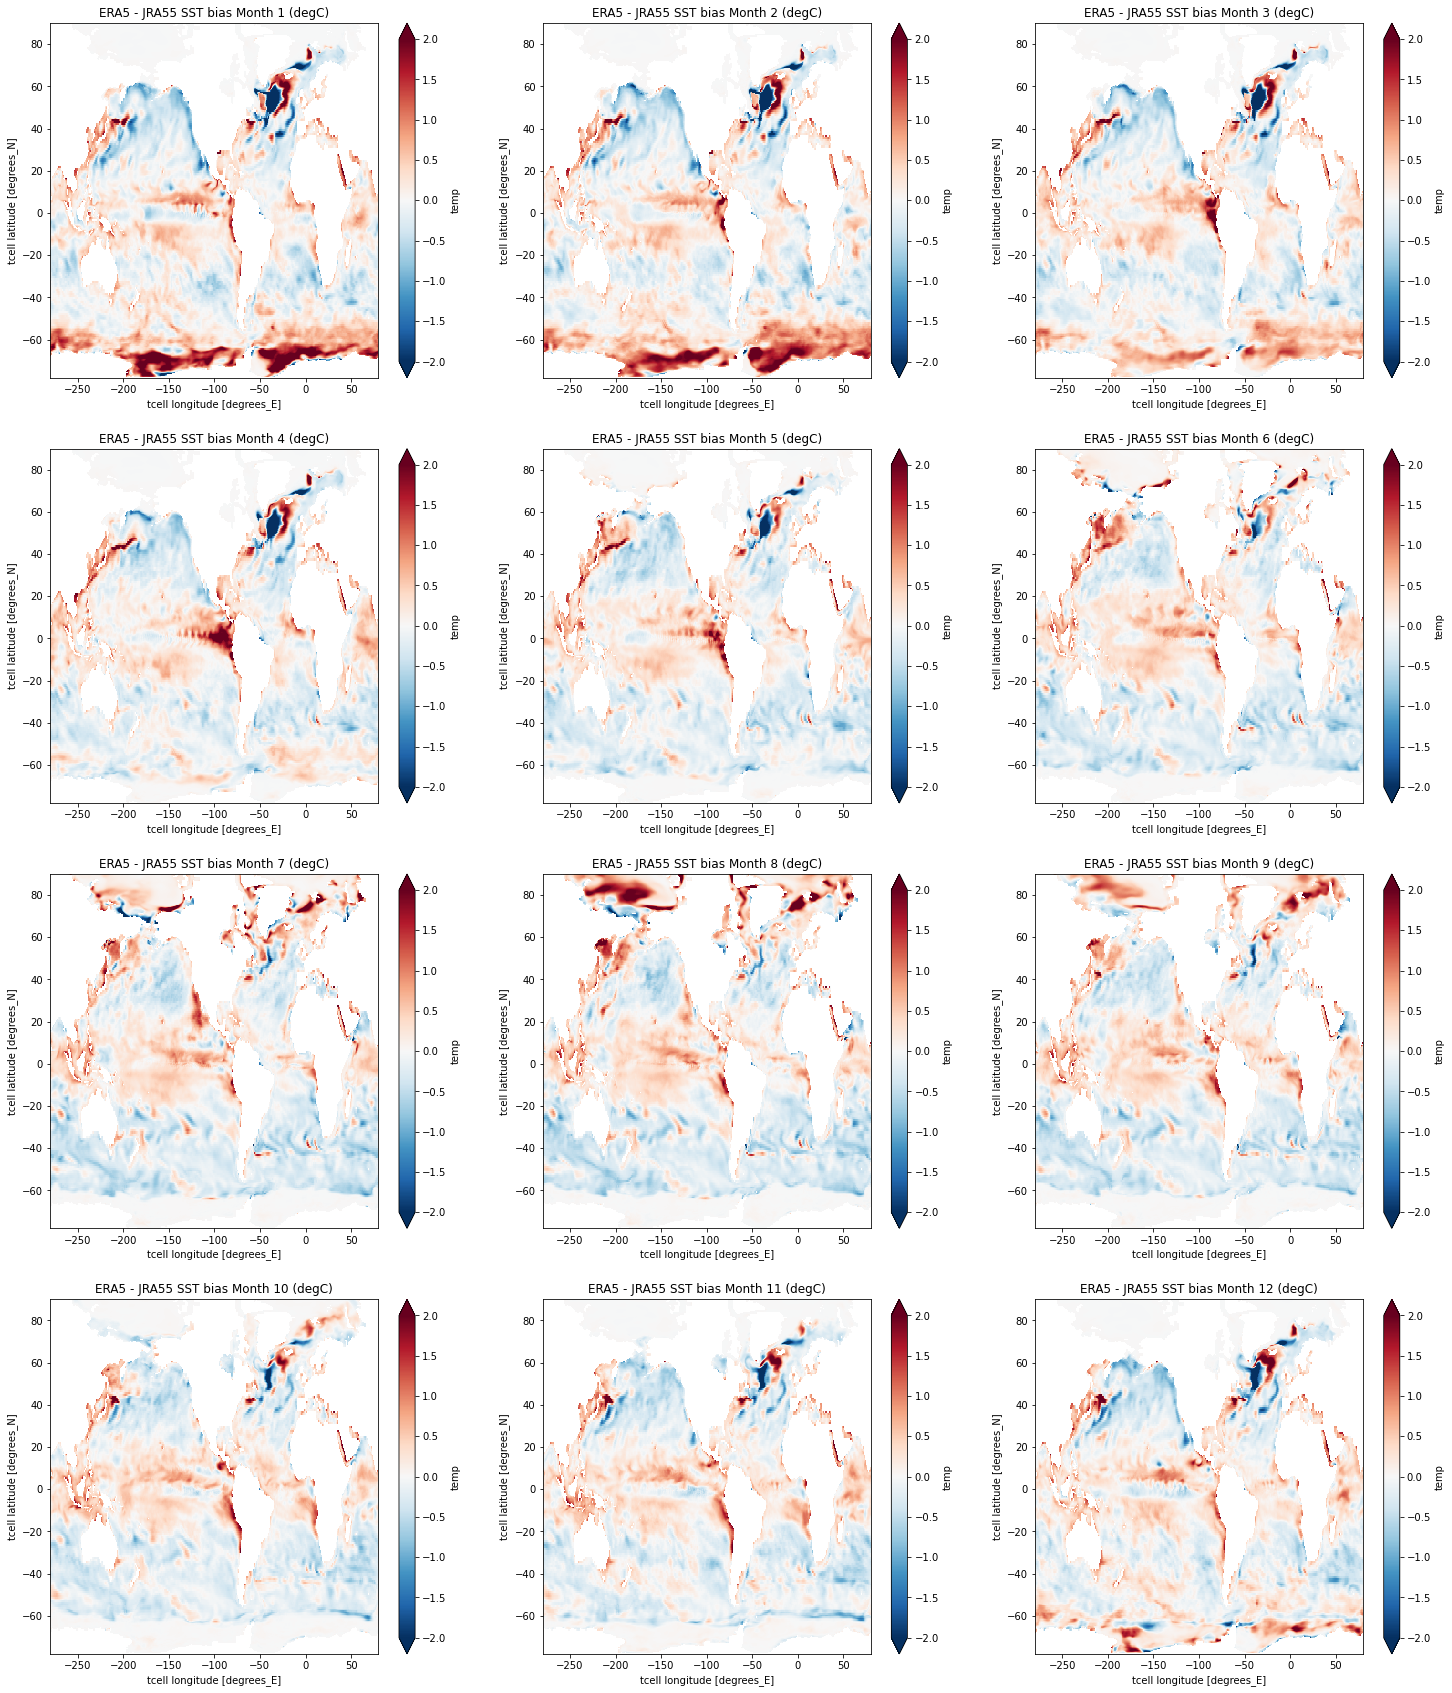

In [18]:
# Seasonal SST differences:
keys = exptdict.keys()
year = '1999'
fig, axes = plt.subplots(nrows=4,ncols=3,figsize=(25,30))
axs = axes.reshape(-1)
for i in range(12):
    ERAexpt = exptdict['1 ERA5 RYF']['expt']
    JRAexpt = exptdict['1 JRA55 RYF']['expt']
    sstERA = cc.querying.getvar(ERAexpt,'temp',session).isel(st_ocean=0).sel(time=slice(year + '-01-01',year + '-12-31')).isel(time=i)
    sstJRA = cc.querying.getvar(JRAexpt,'temp',session).isel(st_ocean=0).sel(time=slice(year + '-01-01',year + '-12-31')).isel(time=i)
    
    (sstERA-sstJRA).plot(ax=axs[i],vmin=-2.,vmax=2.,cmap='RdBu_r')
    axs[i].set_title('ERA5 - JRA55 SST bias Month ' + str(i+1) + ' (degC)')

## Circulation Diagnostics

### Drake Passage Transport

1deg_jra55_ryf
1deg_era5_ryf
CPU times: user 38.2 s, sys: 2.46 s, total: 40.6 s
Wall time: 46.9 s


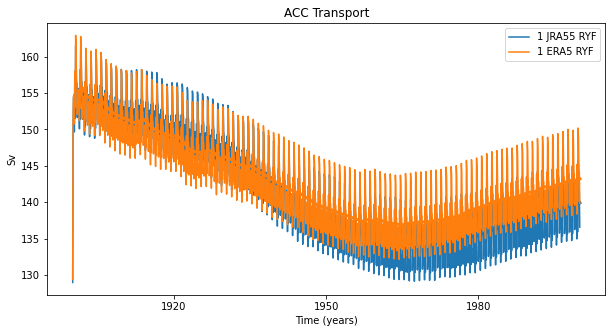

In [19]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/1e6/1036
    DP.plot(label=ekey,color=exptdict[ekey]['color'])
    DP.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)
plt.title("ACC Transport")
plt.xlabel('Time (years)')
plt.ylabel('Sv')
plt.legend()

### AABW overturning circulation @ 55°S

1deg_jra55_ryf


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.88 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.85 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

1deg_era5_ryf


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.88 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

CPU times: user 8min 2s, sys: 21 s, total: 8min 23s
Wall time: 8min 54s


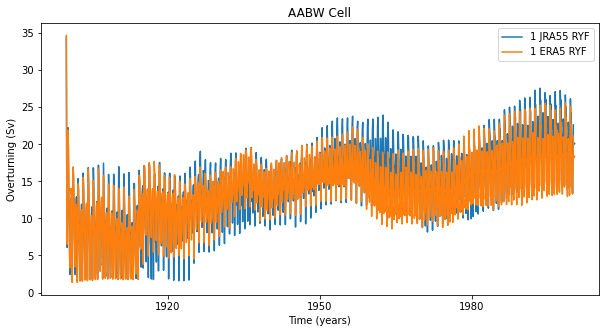

In [20]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_aabw_gm = var2.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
    except:
        print('GM term not found')
    
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
    psi_aabw_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_aabw_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)
plt.title('AABW Cell')
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()

## AABW overturning at 30S:

1deg_jra55_ryf


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.79 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.71 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

1deg_era5_ryf


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

CPU times: user 8min 47s, sys: 24.4 s, total: 9min 11s
Wall time: 9min 44s


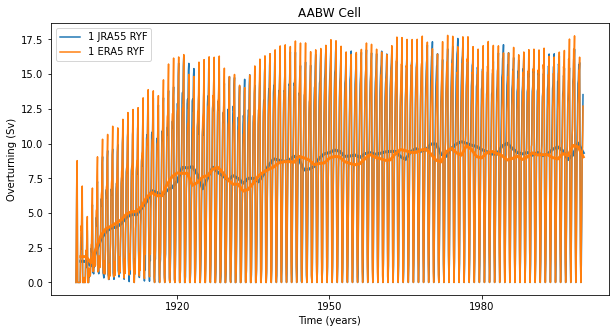

In [21]:
%%time
latitude=-30
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_aabw_gm = var2.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
    except:
        print('GM term not found')
    
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
    psi_aabw_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_aabw_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)
plt.title('AABW Cell')
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()

### AMOC Overturning in density space @ 26°N

1deg_jra55_ryf
1deg_era5_ryf
CPU times: user 7min 15s, sys: 25.8 s, total: 7min 41s
Wall time: 8min 41s


Text(0.5, 1.0, 'AMOC (rho) at 26N')

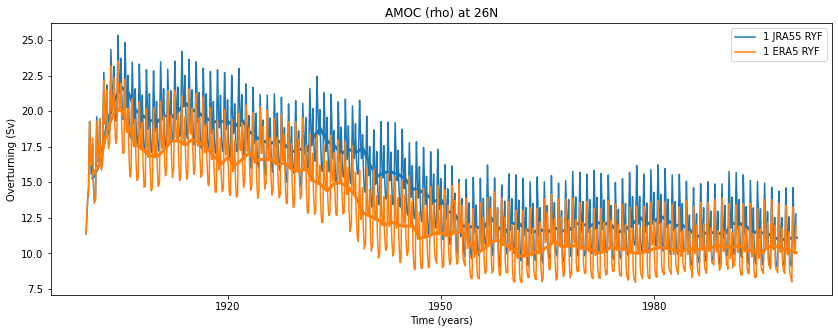

In [28]:
%%time
keys = exptdict.keys()
plt.figure(figsize=(14,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho')
    psi_amoc_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_amoc_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)

#    psi_amoc_sum.plot(label=ekey)#,)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) at 26N')

## AMOC Overturning at 20S

1deg_jra55_ryf
1deg_era5_ryf
CPU times: user 8min 15s, sys: 28 s, total: 8min 43s
Wall time: 10min 7s


Text(0.5, 1.0, 'AMOC (rho) at 30S')

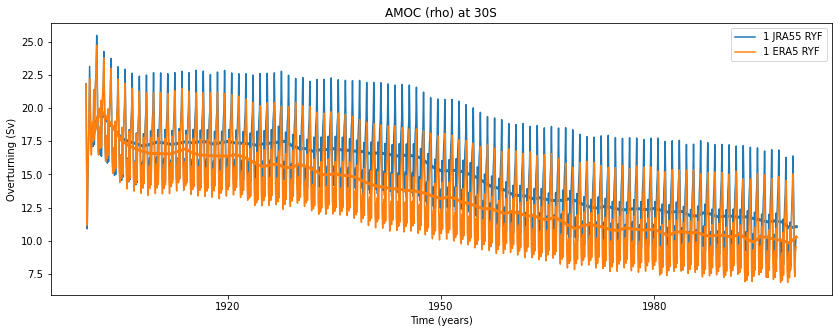

In [29]:
%%time
keys = exptdict.keys()
plt.figure(figsize=(14,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_amoc = var.sel(grid_xt_ocean=slice(-60,20.)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-30)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-60,20.)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-30)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho')
    psi_amoc_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_amoc_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)
    
#    psi_amoc_sum.plot(label=ekey)#,)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) at 30S')

## NADW formation

1deg_jra55_ryf


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.84 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.89 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.78 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

1deg_era5_ryf


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.94 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

CPU times: user 11min 7s, sys: 34.9 s, total: 11min 42s
Wall time: 12min 33s


Text(0.5, 1.0, 'AMOC (rho) formation 40-70N')

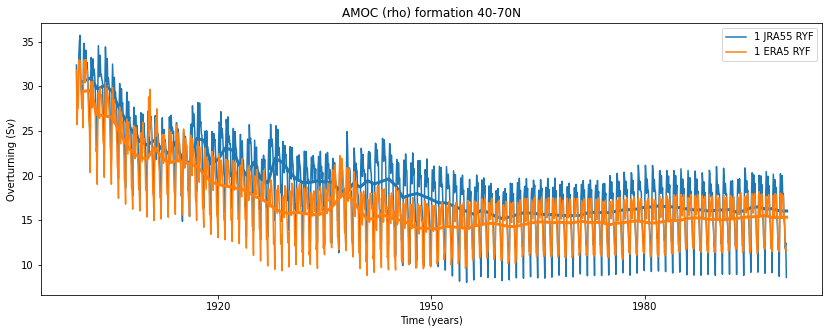

In [30]:
%%time
keys = exptdict.keys()
plt.figure(figsize=(14,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_amoc = var.sum('grid_xt_ocean').sel(grid_yu_ocean=slice(50.,60.))*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_amoc_gm = var2.sum('grid_xt_ocean').sel(grid_yu_ocean=slice(50.,60.))*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').max('grid_yu_ocean')
    psi_amoc_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_amoc_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.)
    
#    psi_amoc_sum.plot(label=ekey)#,)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) formation 40-70N')

## Global Overturning Streamfunction (density)

In [31]:
def plot_psi(psi_avg, clev=np.arange(-25,25,1.)):    
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1032))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

1deg_jra55_ryf
1deg_era5_ryf


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB


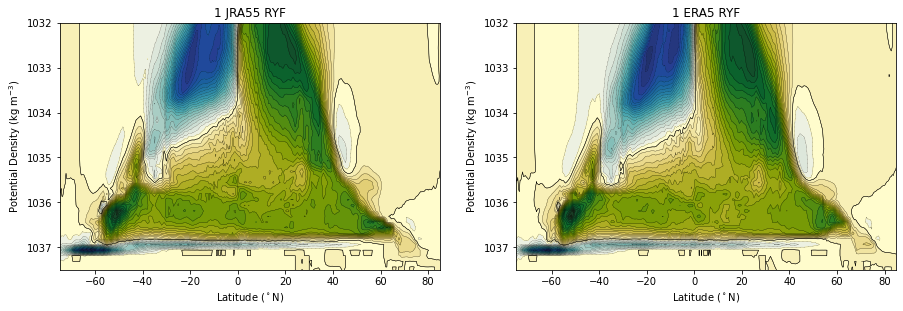

In [32]:
plt.figure(figsize=(15,10))
ii=0
keys = exptdict.keys()
times = ['1995-01-01','2000-01-01']
for ekey in keys:
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi = var.sel(time=slice(times[0],times[1])).mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_gm = var2.sel(time=slice(times[0],times[1])).mean('time').sum('grid_xt_ocean')*1.0e-9
        psi_avg = psi_avg + psi_gm
    except:
        print('GM term not found')
        
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)

1deg_jra55_ryf


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.92 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.98 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

1deg_era5_ryf


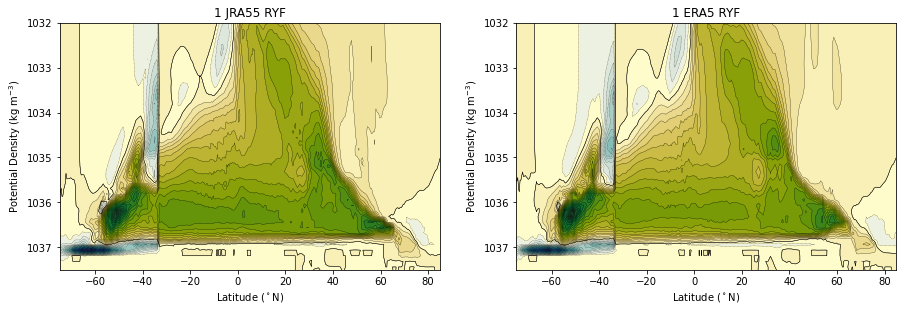

In [33]:
# Atlantic mask:
plt.figure(figsize=(15,10))
ii=0
keys = exptdict.keys()
times = ['1995-01-01','2000-01-01']
for ekey in keys:
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    
    # Atlantic mask:
    ht = cc.querying.getvar(expt,'ht',session,n=-1)
    land_mask = ~ht.isnull()
    
    ## create masks out of the above chunks
    south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
    indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
    indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
    indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
    indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
    indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi = var
    atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
    atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
    atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
    psi = (psi*atlantic_sector_mask).sum('grid_xt_ocean').sel(time=slice(times[0],times[1])).mean('time')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_gm = var2.sel(time=slice(times[0],times[1])).mean('time').sum('grid_xt_ocean')*1.0e-9
        psi_avg = psi_avg + psi_gm
    except:
        print('GM term not found')
        
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)

### Ice Area (in both hemispheres)

In [ ]:
variable='aice_m'
fig,axes = plt.subplots(1,2,figsize=(14,6))
keys = exptdict.keys()
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
    
    
    NH_area.isel(time=slice(0,-1)).plot(ax=axes[0],label=ekey,color=exptdict[ekey]['color'])
    SH_area.isel(time=slice(0,-1)).plot(ax=axes[1],label=ekey,color=exptdict[ekey]['color']) 
    NH_area.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=axes[0],color=exptdict[ekey]['color'],linewidth=4.)
    SH_area.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=axes[1],color=exptdict[ekey]['color'],linewidth=4.)
    
axes[0].set_ylabel(' Ice Area (m$^2$)')
axes[1].legend()
axes[0].set_title('Arctic')
axes[1].set_title('Southern Ocean')

1deg_jra55_ryf


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

In [ ]:
variable='vicen_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
keys = exptdict.keys()
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
    NH_vol.isel(time=slice(0,-1)).plot(ax=ax[0],label=ekey,color=exptdict[ekey]['color'])
    NH_vol.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=ax[0],color=exptdict[ekey]['color'],linewidth=4.)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
    SH_vol.isel(time=slice(0,-1)).plot(ax=ax[1],label=ekey,color=exptdict[ekey]['color'])
    SH_vol.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=ax[1],color=exptdict[ekey]['color'],linewidth=4.)
 
ax[0].set_ylabel('Ice Volume (m$^3$)')
ax[1].legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

# Equatorial Pacific currents:

In [19]:
# Observational SST:
files = []
minyr=1990
maxyr=1991
for yr in np.arange(minyr,maxyr+1,1):
    files += glob.glob('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/*_' + str(yr) + '.nc')
OISST = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True).isel(zlev=0)

In [8]:
keys = exptdict.keys()
times = ['1995-01-01','2000-01-01']
lon = -140.
lats = [-15.,15.]
sst = {}
ssh = {}
u = {}
for i, ekey in enumerate(keys):
    expt = exptdict[ekey]['expt']
    sst[ekey] = cc.querying.getvar(expt,'temp',session).sel(xt_ocean=lon,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).isel(st_ocean=0).sel(time=slice(times[0],times[1])).mean('time')-273.15
    ssh[ekey] = cc.querying.getvar(expt,'sea_level',session,frequency='1 monthly').sel(xt_ocean=lon,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).sel(time=slice(times[0],times[1])).mean('time')
    u[ekey] = cc.querying.getvar(expt,'u',session,frequency='1 monthly').sel(xu_ocean=lon,method='nearest').sel(yu_ocean=slice(lats[0],lats[1])).isel(st_ocean=0).sel(time=slice(times[0],times[1])).mean('time')
    
    sst[ekey].load()
    ssh[ekey].load()
    u[ekey].load()

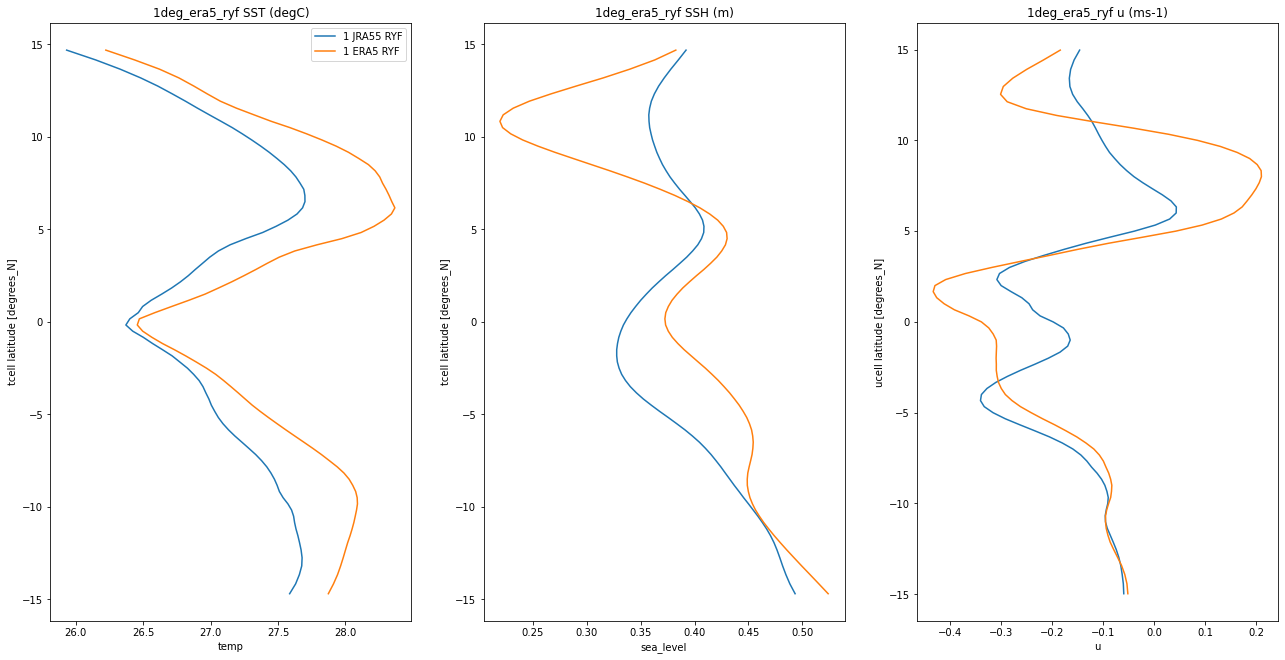

In [18]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(22,11))
for i, ekey in enumerate(keys):
    sst[ekey].plot(y='yt_ocean',ax=axes[0],label=ekey)
    axes[0].set_title(expt + ' SST (degC)')
    ssh[ekey].plot(y='yt_ocean',ax=axes[1])
    axes[1].set_title(expt + ' SSH (m)')
    u[ekey].plot(y='yu_ocean',ax=axes[2])
    axes[2].set_title(expt + ' u (ms-1)')
axes[0].legend()

In [22]:
keys = exptdict.keys()
times = ['1995-01-01','2000-01-01']
ssh = {}
u = {}
for i, ekey in enumerate(keys):
    expt = exptdict[ekey]['expt']
    ssh[ekey] = cc.querying.getvar(expt,'sea_level',session,frequency='1 monthly').sel(time=slice(times[0],times[1])).mean('time')
    u[ekey] = cc.querying.getvar(expt,'u',session,frequency='1 monthly').isel(st_ocean=0).sel(time=slice(times[0],times[1])).mean('time')
    
    ssh[ekey].load()
    u[ekey].load()

Text(0.5, 1.0, 'ERA-5 - JRA-55 u (ms-1)')

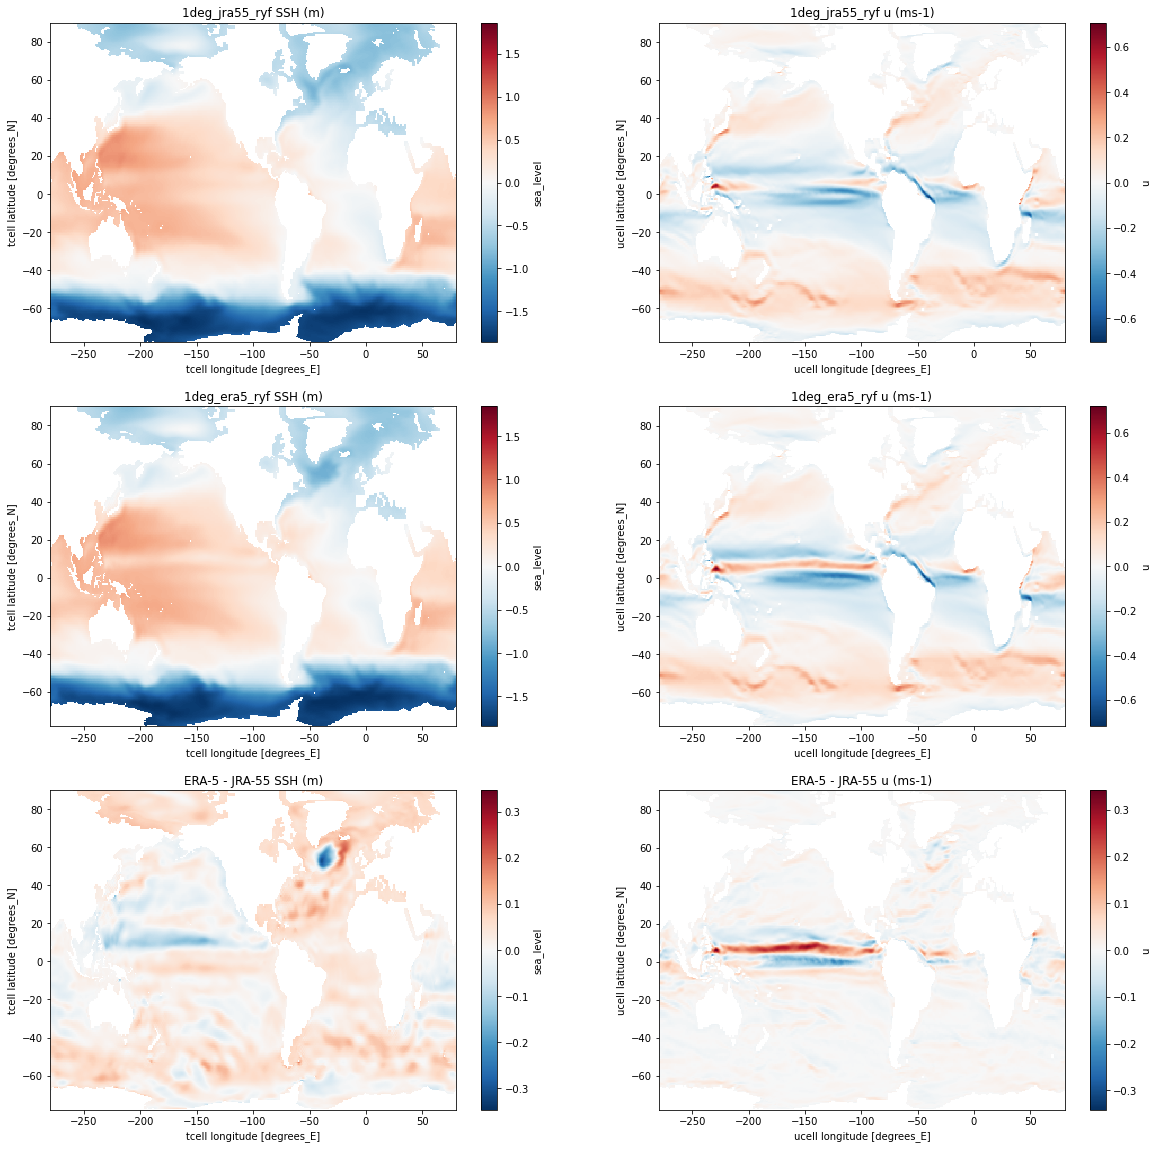

In [35]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,20))
for i, ekey in enumerate(keys):
    expt = exptdict[ekey]['expt']
    ssh[ekey].plot(y='yt_ocean',ax=axes[i][0])
    axes[i][0].set_title(expt + ' SSH (m)')
    u[ekey].plot(y='yu_ocean',ax=axes[i][1])
    axes[i][1].set_title(expt + ' u (ms-1)')
    

(ssh['1 ERA5 RYF']-ssh['1 JRA55 RYF']).plot(y='yt_ocean',ax=axes[i+1][0])
axes[i+1][0].set_title('ERA-5 - JRA-55 SSH (m)')
(u['1 ERA5 RYF']-u['1 JRA55 RYF']).plot(y='yu_ocean',ax=axes[i+1][1])
axes[i+1][1].set_title('ERA-5 - JRA-55 u (ms-1)')

In [26]:
depths = (0,300)    # Define depth range for all plots [m]

EqPlons = (-217,-95) # Define longitude range for longitude-depth plot [degrees]
EqPlat = 0.         # Define latitude for longitude-depth plot [degrees]

Ltlon = -140.       # Define longitude for latitude-depth plot [degrees]
ObsLtlon = 220.     # Define longitude for latitude-depth plot for Johnson observations. [degrees]
Ltlats = (-8,10)    # Define latitudes for latitude-depth plot [degrees]

times = ['1995-01-01','2000-01-01']

### Define data-extract functions for ACCESS-OM2 data:

Define two functions that extract temperature (in degC) and zonal velocity (in cms-1) data from the ACCESS-OM2 simulations defined above. 

In [30]:
# Define function to extract temperature:
def find_temp(ekey):
    
    # Extract required information from experiment dictionary:
    expt = exptdict[ekey]['expt']
    itime = times[0] # Initial time
    ftime = times[1] # Final time
   
    # Define temperature variable using CC (and select correct time slice)
    temp = cc.querying.getvar(expt, 'temp',session,
                          chunks={'st_ocean': None}, frequency='1 monthly',
                             start_time=itime,end_time=ftime)
    
    # Load equatorial longitude-depth slice:
    upper_temp_eq = temp.sel(st_ocean=slice(depths[0],depths[1])).sel(yt_ocean=EqPlat, method='nearest')\
                        .sel(xt_ocean=slice(EqPlons[0],EqPlons[1])).mean('time').load() - 273.15
    upper_temp_eq.attrs['units'] = 'degrees Celsius'
    
    # Load latitude-depth slice:
    upper_temp_140w = temp.sel(st_ocean=slice(depths[0],depths[1])).sel(yt_ocean=slice(Ltlats[0],Ltlats[1]))\
                        .sel(xt_ocean=Ltlon,method='nearest').mean('time').load() - 273.15
    upper_temp_140w.attrs['units'] = 'degrees Celsius'
    
    return upper_temp_eq, upper_temp_140w

# Define function to extract zonal velocity (note that we multiply by 100 to get units of cms-1):
def find_u(ekey):
    
    expt = exptdict[ekey]['expt']
    itime = times[0] # Initial time
    ftime = times[1] # Final time
    # Define zonal velocity using CC (and select correct time slice)
    u = cc.querying.getvar(expt, 'u',session,
                          chunks={'st_ocean': None}, frequency='1 monthly',
                             start_time=itime,end_time=ftime)
    
    # Load equatorial longitude-depth slice:
    upper_u_eq = u.sel(st_ocean=slice(depths[0],depths[1])).sel(yu_ocean=EqPlat, method='nearest')\
                        .sel(xu_ocean=slice(EqPlons[0],EqPlons[1])).mean('time').load()*100
    upper_u_eq.attrs['units'] = 'cms-1'
    
    # Load latitude-depth slice:
    upper_u_140w = u.sel(st_ocean=slice(depths[0],depths[1])).sel(yu_ocean=slice(Ltlats[0],Ltlats[1]))\
                        .sel(xu_ocean=Ltlon,method='nearest').mean('time').load()*100
    upper_u_140w.attrs['units'] = 'cms-1'
    
    return upper_u_eq, upper_u_140w

### Extract Johnson et al. 2002 observational data on the same slices

In [31]:
# Define Johnson observations file:
obs_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')

# Extract temperature:
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

# Extract zonal velocity:
obs_u = obs_file['UM']
obs_u_eq = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_u_140w = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_u_obs = obs_u_140w.YLAT11_101
lon_u_obs = obs_u_eq.XLON

### Plot Equatorial and 140W slices

Now that the data is loaded, we plot it against observations:

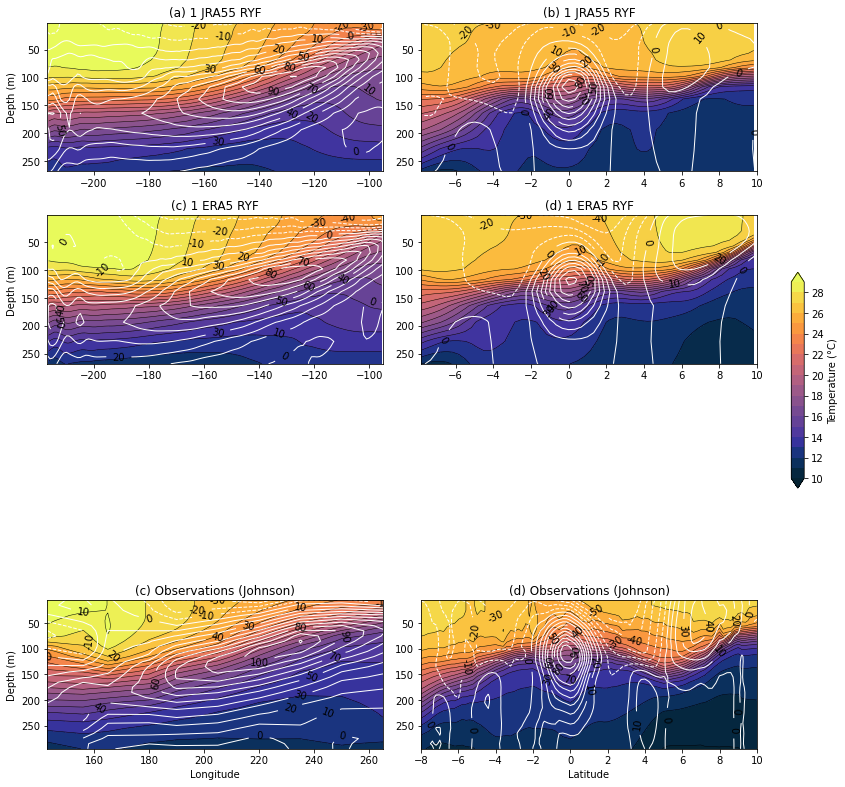

In [33]:
# Define colobar limits and labels:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

labels=['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ','(g) ','(h) ']

fig = plt.figure(figsize=(12,12))

# Select only a few runs for testing:
ekeys = exptdict.keys()

# Loop over experiments:
for i, ekey in enumerate(ekeys):
    
    # Load data:
    upper_temp_eq, upper_temp_140w = find_temp(ekey)
    upper_u_eq, upper_u_140w = find_u(ekey)

    # Plot equatorial slice:
    plt.subplot(4,2,2*i+1)
    p1=upper_temp_eq.plot.contourf(cmap=cm.cm.thermal, 
                                   levels=clevelsT,
                                   add_colorbar=False, extend='both')
    upper_temp_eq.plot.contour(colors='k', levels=clevelsT,
                                   add_colorbar=False,linewidths=0.5)
    xv, yv = np.meshgrid(upper_u_eq.xu_ocean,upper_u_eq.st_ocean)
    p2=plt.contour(xv,yv,upper_u_eq,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('Depth (m)')
    plt.title(labels[2*i] + ekey)
    
    # Plot latitude-depth slice:
    plt.subplot(4,2,2*(i+1))
    p3=upper_temp_140w.plot.contourf(cmap=cm.cm.thermal, 
                                     levels=clevelsT,
                                     add_colorbar=False, extend='both')
    upper_temp_140w.plot.contour(colors='k', levels=clevelsT,
                                     add_colorbar=False,linewidths=0.5)
    xv, yv = np.meshgrid(upper_u_140w.yu_ocean,upper_u_140w.st_ocean)
    p4=plt.contour(xv,yv,upper_u_140w,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(labels[2*i+1] + ekey)

# Plot observational equatorial slice:
plt.subplot(4,2,7)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lon_obs, dep_obs, obs_temp_eq, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
i=i+1
plt.title(labels[i] + 'Observations (Johnson)')

# Plot observational latitude-depth slice:
plt.subplot(4,2,8)
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lat_obs, dep_obs, obs_temp_140w, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('')
i=i+1
plt.title(labels[i] + 'Observations (Johnson)')

# Add colorbar:
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical', extend='both')
cb.ax.set_ylabel('Temperature (°C)')
fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])
#savefigure('equatorial_pacific_RYF')